In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from irrCAC.raw import CAC 
from matplotlib import patheffects as pe
import matplotlib.colors as mcolors

from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import hamming_loss
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportion_confint 
from matplotlib.patches import Patch

In [ ]:
# rename gpt
label_map = {"gpt-4o-2024-08-06": "gpt-4-o"}
fontsize = 28

# Auxiliary functions

In [ ]:
def merge_three_annotators(df1, df2, df3, keys, crit_cols):
    """Return a DataFrame with columns suffixed _a1, _a2, _a3 for given criterion columns."""
    a1 = df1[keys + crit_cols]
    a2 = df2[keys + crit_cols]
    a3 = df3[keys + crit_cols].rename(
        columns={c: f"{c}_a3" for c in crit_cols}
    )

    merged = (
        a1.merge(a2, on=keys, suffixes=("_a1", "_a2"))  
          .merge(a3, on=keys)                        
    )
    return merged

def _find_rater_cols(df_like, dim):
    """
    Return all annotator columns for a dimension, e.g., ["<dim>_a1", "<dim>_a2", "<dim>_a3", ...],
    matched strictly by the pattern ^<dim>_a\\d+$ to avoid accidental matches.
    """
    pat = re.compile(rf"^{re.escape(dim)}_a\d+$")
    return [c for c in df_like.columns if pat.match(c)]

def ac1_per_model_dimension(
    df, model_col, dims, label_map=None, min_raters=2
):
    """
    Return dict keyed by (display_model, dimension) -> AC1 float.
    Works with 2, 3, or more annotators named <dim>_a1, <dim>_a2, <dim>_a3, ...

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing model, item, and annotator columns.
    model_col : str
        Name of the column identifying the model.
    dims : list of str
        List of dimension names (without _aN suffix) to consider.
    label_map : dict, optional
        Mapping from model identifiers to display names. If None, use model identifiers as-is.
    min_raters : int, optional
        Require at least this many rater columns for a dimension within a model; otherwise skip.
    
    Returns
    -------
    dict
        {(display_model, dimension) -> AC1 float}
    """
    if label_map is None:
        label_map = {}
    ac1_map = {}

    for mdl, g in df.groupby(model_col, dropna=False):
        disp = label_map.get(mdl, mdl)
        for d in dims:
            cols = _find_rater_cols(g, d)
            if len(cols) < min_raters:
                continue
            # Coerce to numeric 0/1, drop rows with any missing among these raters
            X = (g[cols]
                 .apply(pd.to_numeric, errors="coerce")
                 .dropna(how="any"))
            if X.empty or X.shape[1] < min_raters:
                continue
            X = X.astype(int)
            # AC1 (Gwet) over all available raters for this dimension & model
            res = CAC(X).gwet()
            ac1 = res["est"]["coefficient_value"]
            ac1_map[(disp, d)] = float(ac1)

    return ac1_map


def aggregated_ac1_per_model(
    df, model_col, dims, label_map=None, how="macro", min_raters=2
):
    """
    Return dict keyed by display_model -> aggregated AC1 float across dimensions.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing model, item, and annotator columns.
    model_col : str
        Name of the column identifying the model.
    dims : list of str
        List of dimension names (without _aN suffix) to consider.
    label_map : dict, optional
        Mapping from model identifiers to display names. If None, use model identifiers as-is.
    how : str, optional
        One of "macro", "weighted_macro", or "micro":
        - "macro": unweighted mean of per-dimension AC1s
        - "weighted_macro": mean of per-dimension AC1s weighted by number of items with complete ratings
        - "micro": compute AC1 on the stacked ratings across all dimensions, using only raters present in all included dimensions
    min_raters : int, optional
        Require at least this many rater columns for a dimension within a model; otherwise skip.
        
    Returns
    -------
    dict
        {display_model -> aggregated AC1 float}
    """
    if label_map is None:
        label_map = {}
    out = {}

    for mdl, g in df.groupby(model_col, dropna=False):
        disp = label_map.get(mdl, mdl)

        per_dim_ac1 = []
        per_dim_n   = []
        stacks = []
        rater_sets = []

        # get per-dimension AC1s and collect matrices
        for d in dims:
            cols = _find_rater_cols(g, d)
            if len(cols) < min_raters:
                continue
            X = (g[cols]
                 .apply(pd.to_numeric, errors="coerce")
                 .dropna(how="any"))
            if X.empty or X.shape[1] < min_raters:
                continue
            Xi = X.astype(int)
            try:
                res = CAC(Xi).gwet()
                ac1 = float(res["est"]["coefficient_value"])
            except Exception:
                continue
            per_dim_ac1.append(ac1)
            per_dim_n.append(len(Xi))
            stacks.append(Xi)
            rater_sets.append(tuple(Xi.columns.tolist()))

        if not per_dim_ac1:
            continue

        if how == "micro":
            # Use only the raters present in all dimensions for this model
            common_cols = None
            for cols in rater_sets:
                common_cols = set(cols) if common_cols is None else (common_cols & set(cols))
            common_cols = None if common_cols is None else sorted(common_cols)

            if not common_cols or len(common_cols) < min_raters:
                # Fallback: if no consistent rater set across dims, default to weighted_macro
                out[disp] = np.average(per_dim_ac1, weights=per_dim_n)
                continue

            stacked_parts = []
            for Xi in stacks:
                # Drop to the common rater set and keep only complete rows
                if not set(common_cols).issubset(set(Xi.columns)):
                    continue
                sub = Xi[common_cols].dropna(how="any")
                if not sub.empty:
                    stacked_parts.append(sub)

            if not stacked_parts:
                out[disp] = np.average(per_dim_ac1, weights=per_dim_n)
                continue

            stacked = pd.concat(stacked_parts, axis=0, ignore_index=True).astype(int)
            try:
                out[disp] = float(CAC(stacked).gwet()["est"]["coefficient_value"])
            except Exception:
                # Fallback if CAC fails on the stack
                out[disp] = np.average(per_dim_ac1, weights=per_dim_n)

        elif how == "weighted_macro":
            out[disp] = float(np.average(per_dim_ac1, weights=per_dim_n))
        else:  # "macro"
            out[disp] = float(np.mean(per_dim_ac1))

    return out


In [ ]:
def compute_means_and_cis(df_combined, criteria_columns, label_map, conf=0.95, method="wilson", agg="any_positive"):
    """
    Compute mean percentages and confidence intervals for each model and criterion. 
    """
    records = []
    alpha = 1.0 - conf

    def aggregate_row(row, crit, agg):
        a1 = row.get(f"{crit}_a1")
        a2 = row.get(f"{crit}_a2")

        vals = [v for v in [a1, a2] if pd.notna(v)]
        
        if not vals:
            return None
        s = sum(vals)
        
        if agg == "both_positive":
            return 1.0 if s == len(vals) and len(vals) > 0 else 0.0
        elif agg == "any_positive":
            return 1.0 if s >= 1 else 0.0
        else:
            raise ValueError(f"Unsupported agg method: {agg}")

    for model, sub in df_combined.groupby("model"):
        model_disp = label_map.get(model, model)
        for crit in criteria_columns:
            # build one label per item
            item_labels = []
            for _, row in sub.iterrows():
                lab = aggregate_row(row, crit, agg)
                if lab is not None:
                    item_labels.append(float(lab))
            n = float(len(item_labels))
            k = float(sum(item_labels))
            mean_pct = 100.0 * (k / n) if n else 0.0
            if n:
                lo, hi = proportion_confint(count=int(k), nobs=int(n), alpha=alpha, method=method)
            else:
                lo, hi = 0.0, 0.0
            records.append({
                "criterion": crit,
                "model": model_disp,
                "n_items": int(n),
                "mean_pct": mean_pct,
                "ci_low": 100.0 * lo,
                "ci_high": 100.0 * hi,
            })

    df = pd.DataFrame(records)
    df_mean    = df.pivot(index="criterion", columns="model", values="mean_pct")
    df_ci_low  = df.pivot(index="criterion", columns="model", values="ci_low")
    df_ci_high = df.pivot(index="criterion", columns="model", values="ci_high")
    for d in (df_mean, df_ci_low, df_ci_high):
        d.columns.name = None
    return df_mean, df_ci_low, df_ci_high

In [ ]:
def compute_means_and_cis(
    df_combined,
    criteria_columns,
    label_map,
    conf=0.95,
    method="wilson",
    agg="majority",  
    threshold=None,        
    min_raters=2,            
    tie_break="majority"    
):
    """
    Compute mean and binomial CIs (Wilson by default) for binary item labels
    obtained by aggregating multiple annotators per item.

    Expected annotator columns per criterion: <criterion>_a1, <criterion>_a2, <criterion>_a3, ...
    
    Parameters
    ----------
    df_combined : pd.DataFrame
        DataFrame containing model, item, and annotator columns.
    min_raters : int
        Require at least this many rater columns for a dimension within a model; otherwise skip.
        Rows with any missing among the selected columns are dropped prior to aggregation.
    agg : str
        Aggregation method: "majority" (default), "any_positive", "both_positive", or "threshold". If "majority", the label gets 1 if more than half of the available annotators are positive.
    threshold : float or None
        If agg="threshold", the proportion threshold in (0,1] to assign label 1. Required if agg="threshold".
    tie_break : str
        If agg="majority" and there's an exact tie (possible with even number of raters or missing labels), resolve via "positive" (1) or "negative" (0).
        
    Returns
    -------
    df_mean : pd.DataFrame
        Wide-format DataFrame of mean percentages, indexed by criterion, columns are models.
    df_ci_low : pd.DataFrame
        Wide-format DataFrame of lower bounds of confidence intervals, indexed by criterion, columns are models.
    df_ci_high : pd.DataFrame
        Wide-format DataFrame of upper bounds of confidence intervals, indexed by criterion, columns are models.
    """
    records = []
    alpha = 1.0 - conf

    def aggregate_row(row, crit):
        # Collect all annotator columns that match <crit>_a<number>
        cols = [c for c in row.index if c.startswith(f"{crit}_a")]
        # Keep only those that truly end with _a<number>
        cols = [c for c in cols if re.match(rf"^{re.escape(crit)}_a\d+$", c)]
        if not cols:
            return None

        vals = [row[c] for c in cols if pd.notna(row[c])]
        if len(vals) < min_raters:
            return None

        m = len(vals)
        s = float(sum(vals))
        prop_pos = s / m

        if agg == "any_positive":
            return 1.0 if s >= 1.0 else 0.0

        elif agg == "both_positive":
            return 1.0 if s == m else 0.0

        elif agg == "majority":
            if prop_pos > 0.5:
                return 1.0
            elif prop_pos < 0.5:
                return 0.0
            else:  # exact tie (possible with even m or missing labels)
                return 1.0 if tie_break == "positive" else 0.0

        elif agg == "threshold":
            if threshold is None:
                raise ValueError("agg='threshold' requires a numeric `threshold` in (0,1].")
            return 1.0 if prop_pos >= float(threshold) else 0.0

        else:
            raise ValueError(f"Unsupported agg method: {agg}")

    for model, sub in df_combined.groupby("model"):
        model_disp = label_map.get(model, model)
        for crit in criteria_columns:
            item_labels = []
            for _, row in sub.iterrows():
                lab = aggregate_row(row, crit)
                if lab is not None:
                    item_labels.append(float(lab))

            n = int(len(item_labels))
            k = int(sum(item_labels))
            mean_pct = 100.0 * (k / n) if n else 0.0

            if n:
                lo, hi = proportion_confint(count=k, nobs=n, alpha=alpha, method=method)
            else:
                lo, hi = 0.0, 0.0

            records.append({
                "criterion": crit,
                "model": model_disp,
                "n_items": n,
                "mean_pct": mean_pct,
                "ci_low":  100.0 * lo,
                "ci_high": 100.0 * hi,
            })

    df = pd.DataFrame(records)

    # Wide tables for plotting
    df_mean     = df.pivot(index="criterion", columns="model", values="mean_pct")
    df_ci_low   = df.pivot(index="criterion", columns="model", values="ci_low")
    df_ci_high  = df.pivot(index="criterion", columns="model", values="ci_high")
    for d in (df_mean, df_ci_low, df_ci_high):
        d.columns.name = None

    return df_mean, df_ci_low, df_ci_high


# Questions

In [17]:
df_annotator1 = pd.read_excel("../../data/ablations/qa/v1/annotate_tpc_15_ann1.xlsx")
df_annotator2 = pd.read_excel("../../data/ablations/qa/v1/annotate_tpc_15_ann2.xlsx")
df_annotator3 = pd.read_excel("../../data/ablations/qa/v1/annotate_tpc_15_ann3.xlsx")

criteria_columns = ["Verifiability", "Passage Independence", "Clarity",
                    "Terminology", "Self-Containment", "Naturalness"]

df_annotator1 = df_annotator1.dropna(subset=criteria_columns)
df_annotator2 = df_annotator2.dropna(subset=criteria_columns)
df_annotator3 = df_annotator3.dropna(subset=criteria_columns)

##df_combined = df_annotator1.merge(
#    df_annotator2, on=["question_id", "model"], suffixes=("_a1", "_a2")
#)
df_combined = merge_three_annotators(
    df_annotator1, df_annotator2, df_annotator3,
    keys=["question_id", "model"],
    crit_cols=criteria_columns,
)

df_combined.head(2)

,question_id,model,Verifiability_a1,Passage Independence_a1,Clarity_a1,Terminology_a1,Self-Containment_a1,Naturalness_a1,Verifiability_a2,Passage Independence_a2,Clarity_a2,Terminology_a2,Self-Containment_a2,Naturalness_a2,Verifiability_a3,Passage Independence_a3,Clarity_a3,Terminology_a3,Self-Containment_a3,Naturalness_a3
0,58,qwen:32b,1,1,1,1,1,1,1,1.0,1.0,1.0,1.0,1.0,1,1,1,1,0,1
1,63,llama3.3:70b,1,1,1,1,1,1,1,1.0,1.0,1.0,1.0,1.0,1,1,1,1,1,1


In [18]:
ac1_map = ac1_per_model_dimension(
    df_combined, model_col="model", dims=criteria_columns, label_map=label_map
)
ac1_agg = aggregated_ac1_per_model(
    df_combined, model_col="model", dims=criteria_columns, label_map=label_map
)

df_models_mean, df_models_ci_low, df_models_ci_high = compute_means_and_cis(
    df_combined, criteria_columns, label_map, conf=0.95, method="wilson"
)

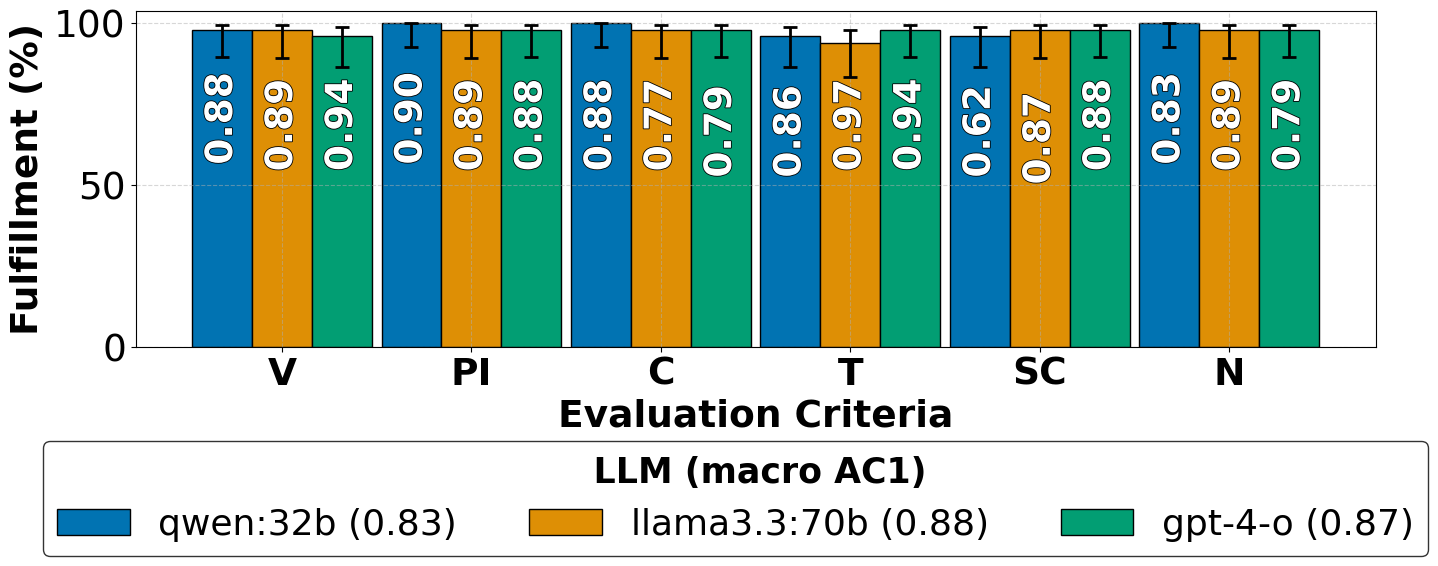

In [19]:
fontsize = 27

# clean up column names
for d in (df_models_mean, df_models_ci_low, df_models_ci_high):
    d.columns.name = None

# --- reorder models (after label_map) ---
models_order = ["qwen:32b", "llama3.3:70b", "gpt-4-o"]  # update to your display names if label_map changed them
df_models_mean    = df_models_mean[models_order]
df_models_ci_low  = df_models_ci_low[models_order]
df_models_ci_high = df_models_ci_high[models_order]

# --- bars (now with asymmetric CI error bars) ---
models = df_models_mean.columns
colorblind_palette = sns.color_palette("colorblind", n_colors=len(models))

fig, ax = plt.subplots(figsize=(16, 7))
bar_width = 0.95 / len(models)
x = np.arange(len(criteria_columns))

for i, (model, color) in enumerate(zip(models, colorblind_palette)):
    means = df_models_mean[model].values
    ci_lo = df_models_ci_low[model].values
    ci_hi = df_models_ci_high[model].values

    # asymmetric error: distance from mean to bounds
    lower = np.maximum(means - ci_lo, 0.0)
    upper = np.maximum(ci_hi - means, 0.0)
    yerr = np.vstack([lower, upper])

    ax.bar(
        x + i * bar_width,
        means,
        yerr=yerr,
        width=bar_width,
        label=model,
        edgecolor="black",
        color=color,
        capsize=5,
        error_kw={'linewidth': 2, 'capthick': 2}
    )

ax.set_xlabel("Evaluation Criteria", fontsize=fontsize, fontweight="bold", color="black")
ax.set_ylabel("Fulfillment (%)", fontsize=fontsize, fontweight="bold", color="black", labelpad=6)

center_offset = bar_width * (len(models) - 1) / 2
ax.set_xticks(x + center_offset)

short_labels = {
    "Verifiability": "V",
    "Passage Independence": "PI",
    "Clarity": "C",
    "Terminology": "T",
    "Self-Containment": "SC",
    "Naturalness": "N"
}
ax.set_xticklabels([short_labels.get(lbl, lbl) for lbl in criteria_columns],
                   fontsize=fontsize, color="black", ha="center", weight="bold")

ax.set_ylim(0, 104)
ax.tick_params(axis="y", labelcolor="black", labelsize=fontsize)
ax.tick_params(axis="x", labelcolor="black", labelsize=fontsize)
ax.grid(True, linestyle="--", alpha=0.5)

for spine in ax.spines.values():
    spine.set_color("black")

fig.subplots_adjust(bottom=0.4)

# Legend with macro AC1 (expects ac1_agg dict keyed by model display names)
handles, labels = ax.get_legend_handles_labels()
labels_with_ac1 = [
    f"{lab} ({ac1_agg[lab]:.2f})" if 'ac1_agg' in globals() and lab in ac1_agg else lab
    for lab in labels
]
legend = fig.legend(
    handles, labels_with_ac1,
    fontsize=fontsize-1, loc="lower center", frameon=True,
    ncol=len(models), bbox_to_anchor=(0.5, 0.075))
legend.set_title(
    "    LLM (macro AC1)", prop=dict(size=fontsize-2, weight="bold"))
legend.get_frame().set_edgecolor("black")


# --- AC1 annotations on bars (expects ac1_map keyed by (model, criterion)) ---
inside_pts  = 35  # points below bar top
outside_pts = 6   # points above errorbar cap

for i, model in enumerate(models):
    for j, dim in enumerate(criteria_columns):
        ac1 = ac1_map.get((model, dim), np.nan) if 'ac1_map' in globals() else np.nan
        if np.isnan(ac1):
            continue

        xpos = x[j] + i * bar_width
        mean = float(df_models_mean.loc[dim, model])
        err_top = float(df_models_ci_high.loc[dim, model])  # CI upper bound

        # If the bar is tall enough, place inside; else above CI cap
        if mean >= 12:
            ax.annotate(
                f"{ac1:.2f}",
                xy=(xpos, mean), xytext=(0, -inside_pts),
                textcoords="offset points", ha="center", va="top",
                fontsize=fontsize, fontweight="bold", color="white",
                path_effects=[pe.withStroke(linewidth=1.2, foreground="black")],
                clip_on=True, zorder=2, rotation=90
            )
        else:
            ax.annotate(
                f"{ac1:.2f}",
                xy=(xpos, err_top), xytext=(0, outside_pts),
                textcoords="offset points", ha="center", va="bottom",
                fontsize=fontsize, fontweight="bold", color="black",
                clip_on=True, zorder=2, rotation=90
            )
#plt.savefig("../../figures/question_quality_evaluation_ac1.pdf", bbox_inches="tight")
plt.show()


In [20]:
# overall
kappa_scores = {col: cohen_kappa_score(df_combined[f"{col}_a1"], df_combined[f"{col}_a2"]) for col in criteria_columns}

df_kappa = pd.DataFrame.from_dict(kappa_scores, orient="index", columns=["Cohen's Kappa"])
df_kappa

,Cohen's Kappa
Verifiability,0.249198
Passage Independence,0.145642
Clarity,0.153156
Terminology,0.182602
Self-Containment,0.214806
Naturalness,0.091285


In [21]:
y_true = df_combined[[f"{col}_a1" for col in criteria_columns]].to_numpy()
y_pred = df_combined[[f"{col}_a2" for col in criteria_columns]].to_numpy()

hamming_score = 1 - hamming_loss(y_true, y_pred)
print(f"Hamming Agreement Score: {hamming_score:.3%}")

Hamming Agreement Score: 87.025%


# Answers

In [22]:
# read files
df_annotator1 = pd.read_excel("../../data/ablations/qa/annotations/v2/answers_eval_ann1.xlsx")

df_annotator2 = pd.read_excel("../../data/ablations/qa/annotations/v2/answers_eval_ann2.xlsx")

df_annotator3 = pd.read_excel("../../data/ablations/qa/annotations/v2/answers_eval_ann3.xlsx")

cols_eval = ["Faithfulness", "Passage Dependence", "Passage Reference Avoidance", "Structured Response", "Language Consistency"]

criteria_columns_source = [f"{col}_s" for col in cols_eval]
criteria_columns_target = [f"{col}_t" for col in cols_eval]

columns_source_keep = ["row_id", "model"] + criteria_columns_source
columns_target_keep = ["row_id", "model"] + criteria_columns_target

# remove any rows with NaN in any of the criteria columns
df_annotator1 = df_annotator1.dropna(subset=criteria_columns_source + criteria_columns_target)
df_annotator2 = df_annotator2.dropna(subset=criteria_columns_source + criteria_columns_target)


df_combined_s = df_annotator1[columns_source_keep].merge(
    df_annotator2[columns_source_keep], on=["row_id", "model"], suffixes=("_a1", "_a2")
)

df_combined_t = df_annotator1[columns_target_keep].merge(
    df_annotator2[columns_target_keep], on=["row_id", "model"], suffixes=("_a1", "_a2")
)

df_combined_s.head(2)

,row_id,model,Faithfulness_s_a1,Passage Dependence_s_a1,Passage Reference Avoidance_s_a1,Structured Response_s_a1,Language Consistency_s_a1,Faithfulness_s_a2,Passage Dependence_s_a2,Passage Reference Avoidance_s_a2,Structured Response_s_a2,Language Consistency_s_a2
0,0,qwen:32b,1,1,1,1,1,1.0,1.0,1,1,1
1,1,qwen:32b,1,1,0,1,1,1.0,1.0,0,1,1


In [23]:
df_annotator1 = pd.read_excel("../../data/ablations/qa/annotations/v2/answers_eval_ann1.xlsx")
df_annotator2 = pd.read_excel("../../data/ablations/qa/annotations/v2/answers_eval_ann2.xlsx")
df_annotator3 = pd.read_excel("../../data/ablations/qa/annotations/v2/answers_eval_ann3.xlsx")

cols_eval = [
    "Faithfulness", "Passage Dependence", "Passage Reference Avoidance",
    "Structured Response", "Language Consistency"]

criteria_columns_source = [f"{col}_s" for col in cols_eval]
criteria_columns_target = [f"{col}_t" for col in cols_eval]

columns_source_keep = ["row_id", "model"] + criteria_columns_source
columns_target_keep = ["row_id", "model"] + criteria_columns_target

# drop nans
df_annotator1 = df_annotator1.dropna(subset=criteria_columns_source + criteria_columns_target)
df_annotator2 = df_annotator2.dropna(subset=criteria_columns_source + criteria_columns_target)
df_annotator3 = df_annotator3.dropna(subset=criteria_columns_source + criteria_columns_target)

df_combined_s = merge_three_annotators(
    df_annotator1, df_annotator2, df_annotator3,
    keys=["row_id", "model"],
    crit_cols=criteria_columns_source,
)

df_combined_t = merge_three_annotators(
    df_annotator1, df_annotator2, df_annotator3,
    keys=["row_id", "model"],
    crit_cols=criteria_columns_target,
)

In [24]:
print(len(df_combined_s))
print(df_combined_s["Structured Response_s_a2"].sum())
print(df_combined_s["Structured Response_s_a1"].sum())

145
145
145


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="irrCAC") # to ignore perfect agreement warnings

# AC1 per model and dimension
ac1_map_s = ac1_per_model_dimension(
    df_combined_s, model_col="model", dims=criteria_columns_source, label_map=label_map
)
ac1_agg_s = aggregated_ac1_per_model(
    df_combined_s, model_col="model", dims=criteria_columns_source, label_map=label_map
)

ac1_map_t = ac1_per_model_dimension(
    df_combined_t, model_col="model", dims=criteria_columns_target, label_map=label_map
)
ac1_agg_t = aggregated_ac1_per_model(
    df_combined_t, model_col="model", dims=criteria_columns_target, label_map=label_map
)

# means + CIs
df_models_s, df_models_s_ci_low, df_models_s_ci_high = compute_means_and_cis(
    df_combined_s, criteria_columns_source, label_map
)
df_models_t, df_models_t_ci_low, df_models_t_ci_high = compute_means_and_cis(
    df_combined_t, criteria_columns_target, label_map
)

models_order = ["qwen:32b", "llama3.3:70b", "gpt-4-o"]
df_models_s = df_models_s[models_order]
df_models_s_ci_low  = df_models_s_ci_low[models_order]
df_models_s_ci_high = df_models_s_ci_high[models_order]

df_models_t = df_models_t[models_order]
df_models_t_ci_low  = df_models_t_ci_low[models_order]
df_models_t_ci_high = df_models_t_ci_high[models_order]

In [26]:
ac1_map_s

{('gpt-4-o', 'Faithfulness_s'): 0.97144,
 ('gpt-4-o', 'Passage Dependence_s'): 0.95656,
 ('gpt-4-o', 'Passage Reference Avoidance_s'): 1.0,
 ('gpt-4-o', 'Structured Response_s'): 1.0,
 ('gpt-4-o', 'Language Consistency_s'): 0.92134,
 ('llama3.3:70b', 'Faithfulness_s'): 0.98621,
 ('llama3.3:70b', 'Passage Dependence_s'): 0.83562,
 ('llama3.3:70b', 'Passage Reference Avoidance_s'): 0.82394,
 ('llama3.3:70b', 'Structured Response_s'): 1.0,
 ('llama3.3:70b', 'Language Consistency_s'): 0.95631,
 ('qwen:32b', 'Faithfulness_s'): 0.81967,
 ('qwen:32b', 'Passage Dependence_s'): 0.66268,
 ('qwen:32b', 'Passage Reference Avoidance_s'): 0.9193,
 ('qwen:32b', 'Structured Response_s'): 0.98592,
 ('qwen:32b', 'Language Consistency_s'): 0.87063}

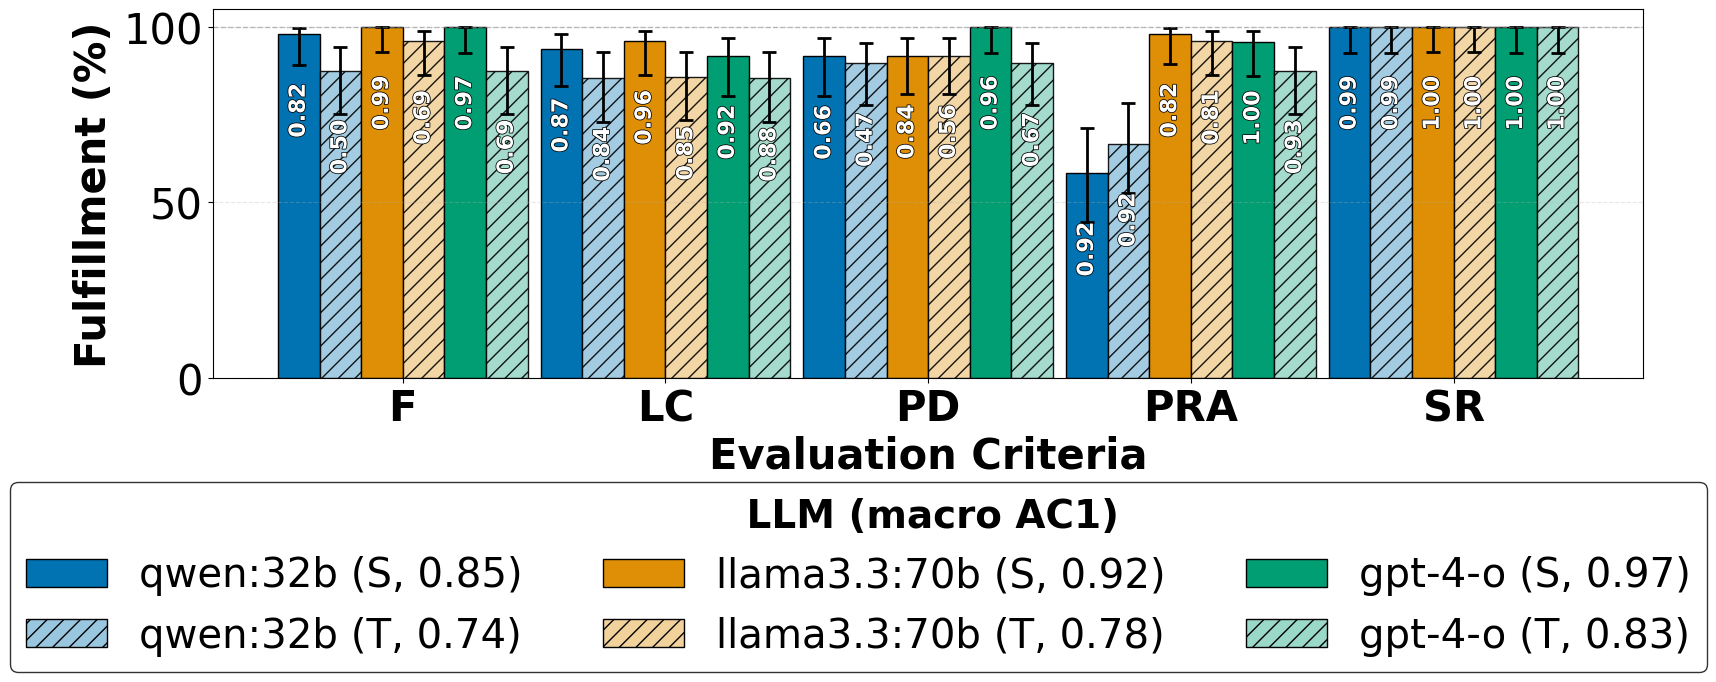

In [ ]:
dims_s = criteria_columns_source
dims_t = criteria_columns_target
fontsize = 30

# model order
models_order = ["qwen:32b", "llama3.3:70b", "gpt-4-o"]
df_models_s          = df_models_s[models_order]
df_models_s_ci_low   = df_models_s_ci_low[models_order]
df_models_s_ci_high  = df_models_s_ci_high[models_order]
df_models_t          = df_models_t[models_order]
df_models_t_ci_low   = df_models_t_ci_low[models_order]
df_models_t_ci_high  = df_models_t_ci_high[models_order]

crit_labels = [c[:-2] if c.endswith("_s") else c for c in df_models_s.index]
crit_names_s = list(df_models_s.index) 
crit_names_t = list(df_models_t.index) 

x = np.arange(len(crit_labels))
models = df_models_s.columns.tolist()
palette = sns.color_palette("colorblind", n_colors=len(models))

def lighten(rgb, factor=0.6):
    r, g, b = mcolors.to_rgb(rgb)
    return (r + (1-r)*factor, g + (1-g)*factor, b + (1-b)*factor)

fig, ax = plt.subplots(figsize=(16, 5))

pairs_per_model = 2
group_width = 0.95
bar_width  = group_width / (len(models) * pairs_per_model)
left_shift = (len(models) * pairs_per_model * bar_width) / 2

for i, (model, color) in enumerate(zip(models, palette)):
    pos_s = x - left_shift + (i * pairs_per_model + 0) * bar_width + bar_width/2
    pos_t = x - left_shift + (i * pairs_per_model + 1) * bar_width + bar_width/2

    # S
    means_s = df_models_s[model].values
    lo_s    = df_models_s_ci_low[model].values
    hi_s    = df_models_s_ci_high[model].values
    yerr_s  = np.vstack([np.maximum(means_s - lo_s, 0.0), np.maximum(hi_s - means_s, 0.0)])
    ax.bar(pos_s, means_s, width=bar_width, color=color, edgecolor="black",
           yerr=yerr_s, capsize=5, label=f"{model} (S)",
           error_kw={'linewidth': 2, 'capthick': 2}
           )

    # T
    means_t = df_models_t[model].values
    lo_t    = df_models_t_ci_low[model].values
    hi_t    = df_models_t_ci_high[model].values
    yerr_t  = np.vstack([np.maximum(means_t - lo_t, 0.0), np.maximum(hi_t - means_t, 0.0)])
    ax.bar(pos_t, means_t, width=bar_width, color=lighten(color), edgecolor="black", error_kw={'linewidth': 2, 'capthick': 2},
           hatch='//', alpha=0.9, yerr=yerr_t, capsize=5, label=f"{model} (T)")

# axes, labels
ax.axhline(100, color="gray", linestyle="--", linewidth=1, alpha=0.5)
short_labels = {
    "Faithfulness": "F","Passage Dependence": "PD","Passage Reference Avoidance": "PRA",
    "Structured Response": "SR","Language Consistency": "LC",
}
ax.set_xticks(x)
ax.set_xticklabels([short_labels.get(lbl, lbl) for lbl in crit_labels],
                   fontsize=fontsize, color="black", ha="center", weight="bold")
ax.set_xlabel("Evaluation Criteria", fontsize=fontsize, fontweight="bold", color="black")
ax.set_ylabel("Fulfillment (%)", fontsize=fontsize, fontweight="bold", color="black", labelpad=6)
ax.set_ylim(0, 105) 
ax.tick_params(axis="y", labelsize=fontsize)
ax.tick_params(axis="x", labelsize=fontsize)
ax.grid(axis="y", linestyle="--", alpha=0.3)

# ---------- Legend at bottom with macro AC1 ----------
legend_handles, legend_labels = [], []
for model, color in zip(models, palette):
    s = ac1_agg_s.get(model, np.nan)
    t = ac1_agg_t.get(model, np.nan)
    legend_handles += [
        Patch(facecolor=color, edgecolor="black"),
        Patch(facecolor=lighten(color), edgecolor="black", hatch='//')
    ]
    legend_labels += [
        f"{model} (S, {s:.2f})" if np.isfinite(s) else f"{model} (S)",
        f"{model} (T, {t:.2f})" if np.isfinite(t) else f"{model} (T)"
    ]

legend = fig.legend(legend_handles, legend_labels, fontsize=fontsize-1, loc="lower center",
                    frameon=True, ncol=3, bbox_to_anchor=(0.5, 0.-0.4))
legend.set_title("           LLM (macro AC1)", prop=dict(size=fontsize-2, weight="bold"))
legend.get_frame().set_edgecolor("black")
fig.subplots_adjust(bottom=0.28)  # room for legend


inside_pts, outside_pts = 35, 10
headroom_needed = 4

for i, model in enumerate(models):
    pos_s = x - left_shift + (i * pairs_per_model + 0) * bar_width + bar_width/2
    pos_t = x - left_shift + (i * pairs_per_model + 1) * bar_width + bar_width/2

    # --- S ---
    means_s = df_models_s[model].values
    hi_s    = df_models_s_ci_high[model].values
    for j, dim in enumerate(crit_names_s):
        v = ac1_map_s.get((model, dim), np.nan)
        if not np.isfinite(v): 
            continue
        top = hi_s[j] if np.isfinite(hi_s[j]) else means_s[j]
        place_inside = (ax.get_ylim()[1] - top) >= headroom_needed

        ax.annotate(f"{v:.2f}",
            xy=(pos_s[j], means_s[j]),
            xytext=(0, -inside_pts) if place_inside else (0, outside_pts),
            textcoords="offset points",
            ha="center", va="top" if place_inside else "bottom",
            fontsize=16, fontweight="bold",
            color="white" if place_inside else "black",
            path_effects=[pe.withStroke(linewidth=1.1, foreground="black")] if place_inside else None,
            clip_on=place_inside,             
            annotation_clip=False,            
            zorder=5,
            rotation=90
            )

    # --- T ---
    means_t = df_models_t[model].values
    hi_t    = df_models_t_ci_high[model].values
    for j, dim in enumerate(crit_names_t):
        v = ac1_map_t.get((model, dim), np.nan)
        if not np.isfinite(v): 
            continue
        top = hi_t[j] if np.isfinite(hi_t[j]) else means_t[j]
        place_inside = (ax.get_ylim()[1] - top) >= headroom_needed

        ax.annotate(f"{v:.2f}",
            xy=(pos_t[j], means_t[j]),
            xytext=(0, -inside_pts) if place_inside else (0, outside_pts),
            textcoords="offset points",
            ha="center", va="top" if place_inside else "bottom",
            fontsize=16, fontweight="bold",
            color="white" if place_inside else "black",
            path_effects=[pe.withStroke(linewidth=1.1, foreground="black")] if place_inside else None,
            clip_on=place_inside,            
            annotation_clip=False,
            zorder=5,
            rotation=90
            )

plt.tight_layout()
#plt.savefig("../../figures/answer_quality_evaluation_ac1.pdf", bbox_inches="tight")
plt.show()
